In [15]:
import fenics as fe
import mshr as ms
import matplotlib.pyplot as plt

# Mesh parameters
POINTS_PER_AXIS = 50
INLET_VELOCITY = 1 # m/s

# Simulation parameters
SIMULATION_TIME = 10
TIME_STEP_LENGTH = 0.005
N_TIME_STEPS = int(SIMULATION_TIME/TIME_STEP_LENGTH) 

# Fluid properties
DENSITY = 1 # kg/m^3
VISCOSITY = 10**-2 # Pa*s (N*s/m^2)
THERMAL_CONDUCTIVITY = 0.598 # W/(m * K)
SPECIFIC_HEAT_CAPACITY = 4184 # J/(kg * K)

print('(Derived constants)')
print(f'Reybolds Number (Re): {DENSITY*INLET_VELOCITY/VISCOSITY:.5f}')

print('(Simulation)')
print(f'Time step: {TIME_STEP_LENGTH}')
print(f'Total time: {SIMULATION_TIME}')
print(f'Iterations: {N_TIME_STEPS}')
print(f'Mesh density: {POINTS_PER_AXIS}')

# Define mesh
mesh = fe.UnitSquareMesh(POINTS_PER_AXIS,POINTS_PER_AXIS,'crossed')
print('Number of cell elements:',mesh.num_cells())

# Form compiler options
fe.parameters["form_compiler"]["optimize"]     = True
fe.parameters["form_compiler"]["cpp_optimize"] = True
fe.parameters["form_compiler"]["representation"] = "uflacs"
fe.set_log_active(False) # suspend FEniCS output

# Define the function spaces

# Taylor-Hood Elements. The order of the function space for the pressure has
# to be one order lower than for the velocity
velocity_function_space = fe.VectorFunctionSpace(mesh, "Lagrange", 2)
pressure_function_space = fe.FunctionSpace(mesh, "Lagrange", 1)
heat_function_space = fe.FunctionSpace(mesh,'Lagrange', 1)

# Define the trial and test functions
u = fe.TrialFunction(velocity_function_space)
v = fe.TestFunction(velocity_function_space)
p = fe.TrialFunction(pressure_function_space)
q = fe.TestFunction(pressure_function_space)
t = fe.TrialFunction(heat_function_space)
w = fe.TestFunction(heat_function_space)

# Define the solution fields involved
u_prev = fe.Function(velocity_function_space) # velocity at previous time step, used for time integration
u_tent = fe.Function(velocity_function_space) # velocity before pressure correction
u_next = fe.Function(velocity_function_space,name='Velocity') # velocity after pressure correction, at current time step
p_next = fe.Function(pressure_function_space,name='Pressure') # pressure at current time step
t_prev = fe.Function(heat_function_space)
t_next = fe.Function(heat_function_space,name='Heat')

# Define the Boundary Condition
walls = 'on_boundary'
top_boundary = 'on_boundary && (x[1] - DOLFIN_EPS < 1.0)'
bottom_boundary = 'on_boundary && (x[1] + DOLFIN_EPS > 0.0)'
left_boundary = 'on_boundary && (x[0] + DOLFIN_EOS > 0.0)'
right_boundary = 'on_boundary && (x[0] - DOLFIN_EPS < 1)'

inflow = fe.Constant((INLET_VELOCITY, 0.0))
noslip = fe.Constant((0.0, 0.0))

velocity_boundary_conditions = [
    fe.DirichletBC(velocity_function_space, noslip, walls),
    fe.DirichletBC(velocity_function_space, inflow, top_boundary)
]

pressure_boundary_conditions = [
    fe.DirichletBC(pressure_function_space, 0.0, top_boundary)
]

heat_boundary_conditions = [
    fe.DirichletBC(heat_function_space, 0, walls),
    fe.DirichletBC(heat_function_space, 15, top_boundary),
]

# Define weak forms
dt = fe.Constant(TIME_STEP_LENGTH)
rho = fe.Constant(DENSITY)
nu = fe.Constant(VISCOSITY / DENSITY)
kappa = fe.Constant(THERMAL_CONDUCTIVITY/(DENSITY*SPECIFIC_HEAT_CAPACITY))

# Weak form of the momentum equation
momentum_residuum = (
    (1.0 / dt) * fe.inner(u - u_prev, v) * fe.dx
    +
    fe.inner(fe.grad(u_prev) * u_prev, v) * fe.dx
    +
    nu * fe.inner(fe.grad(u), fe.grad(v)) * fe.dx)


# Weak form of the pressure poisson problem
pressure_poisson_residuum = (
    fe.inner(fe.grad(p), fe.grad(q)) * fe.dx
    +
    (rho / dt) * fe.div(u_tent) * q * fe.dx
)

# Weak form of the velocity update equation
velocity_update_residuum = (
    fe.inner(u, v) * fe.dx
    -
    fe.inner(u_tent, v) * fe.dx
    +
    (dt/rho) * fe.inner(fe.grad(p_next), v) * fe.dx)

# Weak form of heat transfer equation
heat_residuum = (
    (1.0 / dt) * fe.inner(t - t_prev, w) * fe.dx
    +
    fe.inner(u_next, fe.grad(t_prev)) * w * fe.dx 
    +
    kappa * fe.inner(fe.grad(t), fe.grad(w)) * fe.dx
)

# Assemble system matricies
# used to solve linear (Ax=b) systems 
momentum_lhs = fe.lhs(momentum_residuum)
momentum_rhs = fe.rhs(momentum_residuum)
momentum_A = fe.assemble(momentum_lhs)

pressure_poisson_lhs = fe.lhs(pressure_poisson_residuum)
pressure_poisson_rhs = fe.rhs(pressure_poisson_residuum)
pressure_poisson_A = fe.assemble(pressure_poisson_lhs)

velocity_update_lhs = fe.lhs(velocity_update_residuum)
velocity_update_rhs = fe.rhs(velocity_update_residuum)
velocity_update_A = fe.assemble(velocity_update_lhs)

heat_lhs = fe.lhs(heat_residuum)
heat_rhs = fe.rhs(heat_residuum)
heat_A = fe.assemble(heat_lhs)

(Derived constants)
Reybolds Number (Re): 100.00000
(Simulation)
Time step: 0.005
Total time: 10
Iterations: 2000
Mesh density: 50
Number of cell elements: 10000


In [16]:
# Time loop
from tqdm import tqdm  # for progress bar

# Creating file for saving results
with fe.XDMFFile(fe.MPI.comm_world,f'LidDrivenCavity.xdmf') as file:
    file.parameters.update(
        {
            "functions_share_mesh": True,
            "rewrite_function_mesh": False
        })
    
    # Saving initial states
    file.write(u_next,0)
    file.write(p_next,0)
    file.write(t_next,0)

    # Simulation
    for iter in tqdm(range(N_TIME_STEPS)):
        # (1) Solve for tentative velocity
        momentum_b = fe.assemble(momentum_rhs)
        [bc.apply(momentum_A, momentum_b)
            for bc in velocity_boundary_conditions]
        fe.solve(
            momentum_A,
            u_tent.vector(),
            momentum_b,
            "gmres",
            "ilu",
        )
        
        # (2) Solve for the pressure
        pressure_poisson_b = fe.assemble(pressure_poisson_rhs)
        [bc.apply(pressure_poisson_A, pressure_poisson_b)
            for bc in pressure_boundary_conditions]
        fe.solve(
            pressure_poisson_A,
            p_next.vector(),
            pressure_poisson_b,
            "gmres",
            "amg",
        )

        # (3) Correct the velocities to be incompressible
        velocity_update_b = fe.assemble(velocity_update_rhs)
        [bc.apply(velocity_update_A, velocity_update_b)
            for bc in velocity_boundary_conditions]
        fe.solve(
            velocity_update_A,
            u_next.vector(),
            velocity_update_b,
            "gmres",
            "ilu",
        )

        # (4) Solve heat advection-diffusion equation
        # heat_b = fe.assemble(heat_rhs)
        # [bc.apply(heat_A, heat_b) for bc in heat_boundary_conditions]
        # fe.solve(
        #     heat_A,
        #     t_next.vector(),
        #     heat_b,
        #     "gmres",
        #     "amg",
        # )

        # Save to file
        file.write(u_next,iter*TIME_STEP_LENGTH)
        file.write(p_next,iter*TIME_STEP_LENGTH)
        # file.write(t_next,iter*TIME_STEP_LENGTH)

        # Advance in time
        t_prev.assign(t_next)
        u_prev.assign(u_next)


100%|██████████| 2000/2000 [24:00<00:00,  1.39it/s]


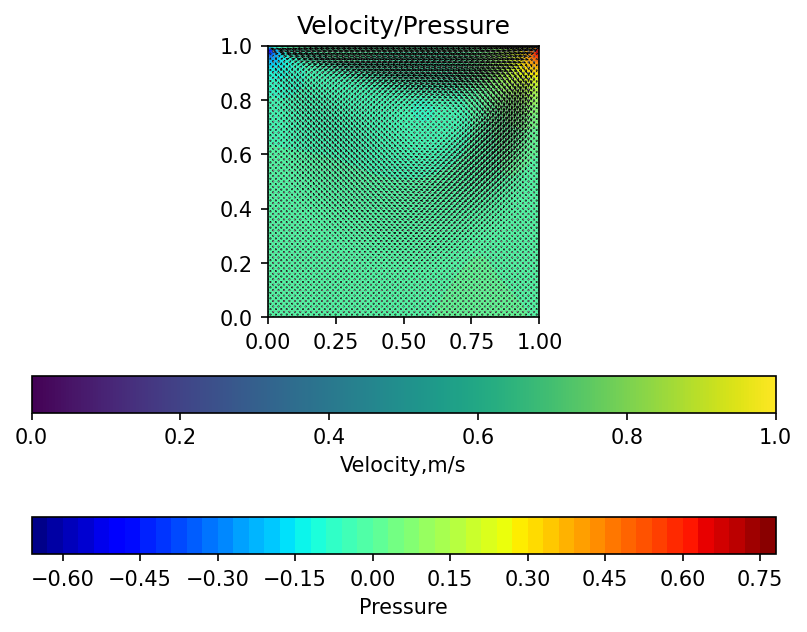

In [17]:
# Plot results
import matplotlib.pyplot as plt

plt.figure(dpi=150)

pressure_plot = fe.plot(p_next,
                        cmap='jet',
                        levels=50)
plt.colorbar(pressure_plot,
             label='Pressure',
             location='bottom')

velocity_plot = fe.plot(u_next,
                        edgecolor='black',
                        linewidth=0.5,
                        minshaft=1,
                        minlength=1.5,
                        title='Velocity/Pressure',)
plt.colorbar(velocity_plot,
             label='Velocity,m/s',
             location='bottom')
fe.plot(mesh, linewidth=0.1)
plt.show()


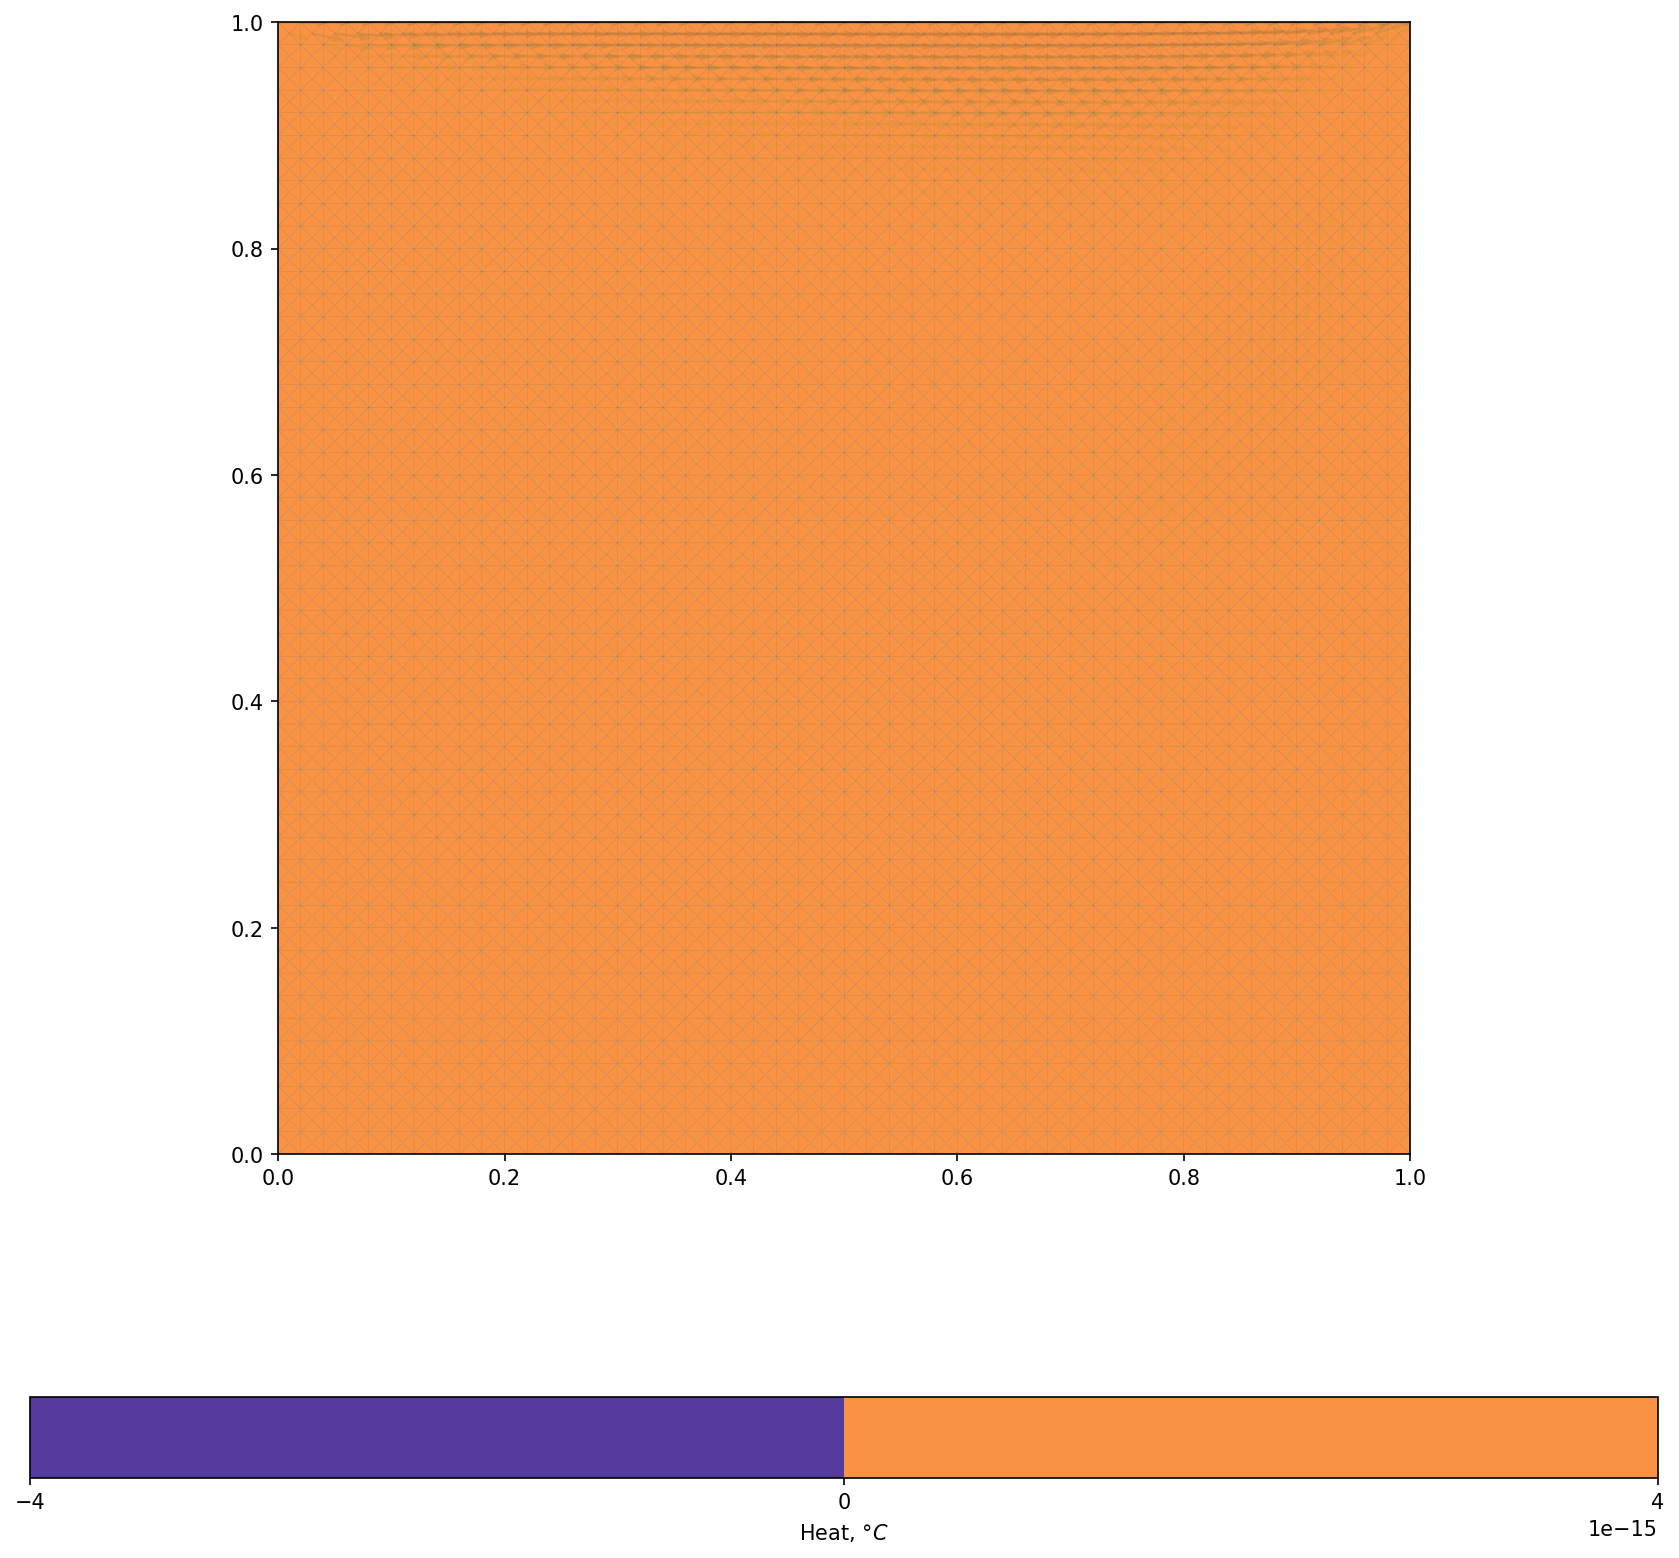

In [18]:
# Plot heat
import cmocean

plt.figure(figsize=(14, 14), dpi=150)
heat_plot = fe.plot(
    t_next, 
    cmap=cmocean.cm.thermal,
    levels=50)
#fe.plot(t_next,mode='contour',levels=10,cmap='coolwarm')
plt.colorbar(heat_plot, label='Heat, $\degree C$',location='bottom')
fe.plot(mesh, linewidth=0.1)
fe.plot(u_next,edgecolor='white',cmap=cmocean.cm.speed,alpha=0.1)
plt.show()

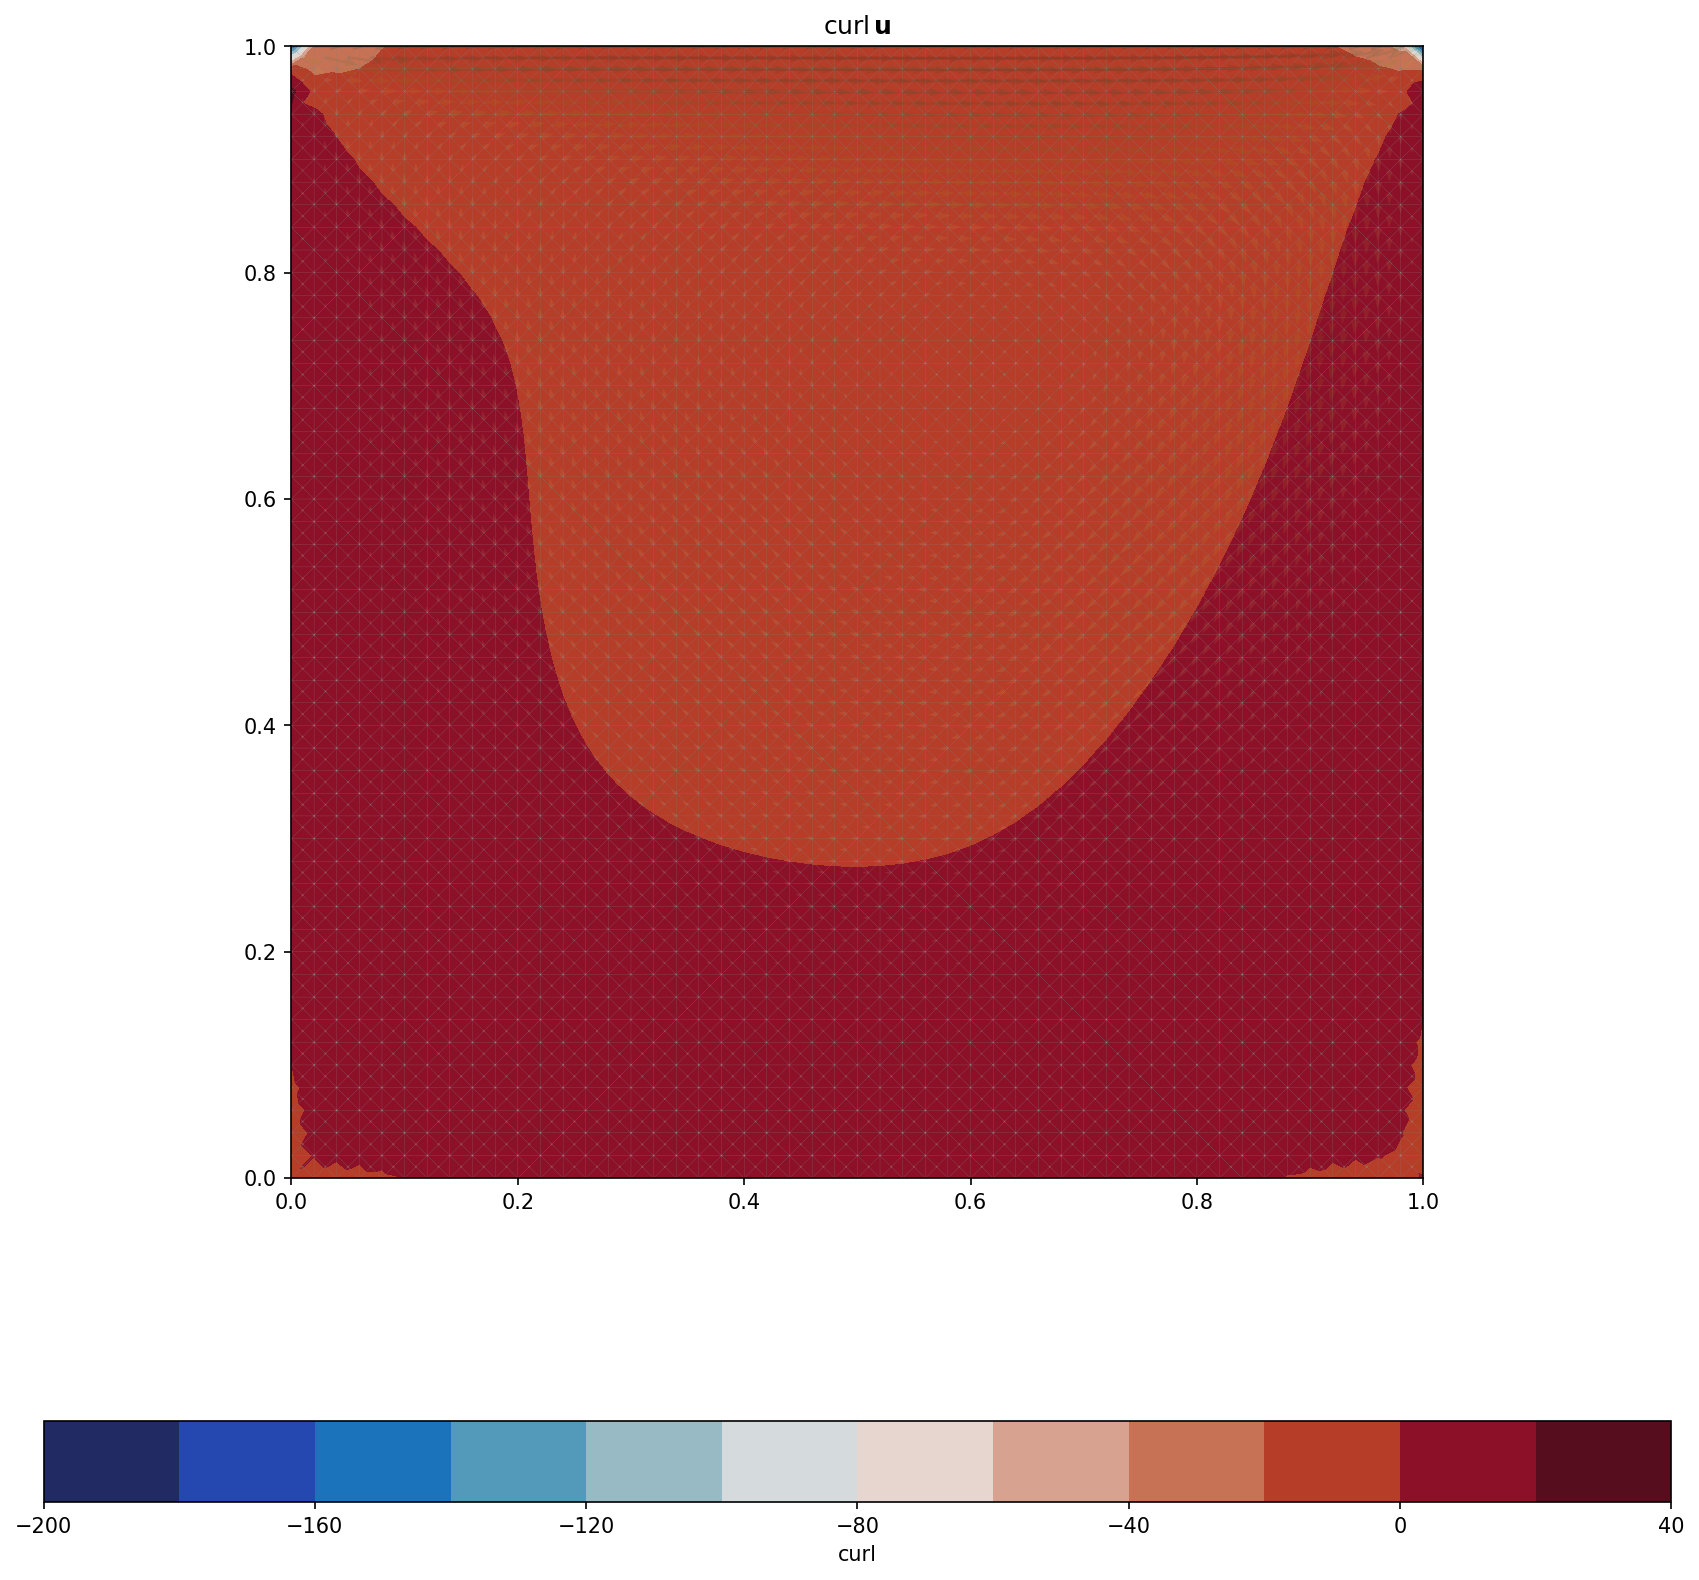

In [19]:
# Plot curl
import cmocean

plt.figure(figsize=(14, 14), dpi=150)
curl_plot = fe.plot(fe.curl(u_next), 
                    cmap=cmocean.cm.balance,
                    levels=10,
                    title='$\operatorname{curl} \mathbf{u}$')
plt.colorbar(curl_plot, label='curl',location='bottom')
fe.plot(mesh, linewidth=0.1)
fe.plot(u_next,cmap=cmocean.cm.speed,alpha = 0.1)
plt.show()